## Model Result Analysis

In [249]:
# change cwd above src
import os
if str(os.getcwd())[-3:] == 'src': 
    os.chdir(str(os.getcwd())+'/..')
    print(os.getcwd())

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import datetime
import yaml
from abc import ABCMeta, abstractmethod
from sklearn.model_selection import TimeSeriesSplit
from visualization.visualize import plot_model_evaluation

In [250]:
# get list of experiments run
experiment_files = [experiment.split('/')[-1] for experiment in glob("results/experiments/*", recursive = True)]
experiments = [experiment.replace('_', ' ') for experiment in experiment_files]
print('DIFFERENT EXPERIMENTS RUN...\n')
for i, experiment in enumerate(experiments):
    print(f"    {i+1}. {experiment}")

DIFFERENT EXPERIMENTS RUN...

    1. ANN DWT WINDOWED
    2. TEST
    3. ANN CEEMDAN FRAGMENTS
    4. ANN BASIC
    5. ANN BASIC V2
    6. ANN BASIC FRAGMENT
    7. ANN BASIC VIRTUAL
    8. ANN CEEMDAN WINDOWED
    9. ANN DWT FRAGMENTS


In [327]:
forecast_avg[col].mean(axis=1)

0      1.118361
1      0.400162
2     -0.081487
3     -0.203842
4     -0.137540
         ...   
659         NaN
660         NaN
661         NaN
662         NaN
663         NaN
Length: 664, dtype: float64

In [336]:
# Print multi validation metric for each experiment
report_metrics = ['MSE', 'MSE_std', 'MAPE', 'MAPE_std']
comparison_df = pd.DataFrame(index=report_metrics)
forecast_datasets = {}

# iterate over experiments
for n, test in enumerate(experiment_files): 
    print(f"\n{n+1}. {experiments[n]}")

    # pre-allocate forecast dict
    forecast_datasets[experiments[n]] = {}

    # get path to experiment result file
    path = "results/experiments/"+test+"/*"
    tests = [test[:-4] for test in glob(path, recursive = True)]
    forecasts = [forecast for forecast in tests if forecast.split('_')[-1] == 'forecast']
    metrics  = [metric for metric in tests if metric.split('_')[-1] == 'metrics']
    
    # separate forecast results and join decompositions
    for forecast in forecasts:
        df_forecast = pd.read_csv(forecast+'.csv')
        if ('CEEMDAN' in forecast.split('/')[-1].split('_')) or ('DWT' in forecast.split('/')[-1].split('_')): 
            label = ' '.join(forecast.split('/')[-1].split('_')[1].upper())
            # sum decomposition elements
            if label not in forecast_datasets[experiments[n]].keys():
                forecast_datasets[experiments[n]][label] = df_forecast
            else: 
                forecast_datasets[experiments[n]][label] += df_forecast

            print(f"\n{label}")
        else: 
            label = ' '.join(forecast.split('/')[-1].split('_')[1].upper())
            forecast_datasets[experiments[n]][label] = df_forecast
            print(f"\n{label}")

        
        print(mean_vals)


    # separate metric results
    for metric in metrics:
        # assign label
        if ('CEEMDAN' not in metric.split('/')[-1].split('_')) or ('DWT' not in metric.split('/')[-1].split('_')): 
            label = ' '.join([experiments[n]] + [metric.split('/')[-1].split('_')[1].upper()])
            print(f"\n{label}") 
            # get table of metrics
            df_metric = pd.read_csv(metric+'.csv').set_index('Fold')
            df_metric = df_metric.rename(columns={col: '_'.join(col.split('_')[:-1]) for col in df_metric.columns if col.split('_')[-1] == 'mean'})
            print(df_metric)
            mean_vals = df_metric.loc['mean', report_metrics].T
            comparison_df[str(label)] = mean_vals
            
        print(mean_vals)

# get metric for DWT and CEEMDAN
# Combine decomposed forecasts
report_metrics = ['MSE', 'MSE_std', 'MAPE', 'MAPE_std']
tests = [test for test in forecast_datasets.keys() if ('DWT' in test.split()) or ('CEEMDAN' in test.split())]
for experiment in tests: 
    # key metrics
    for dma in forecast_datasets[experiment].keys(): 
        no_folds = max([int(col[-3]) for col in forecast_datasets[experiment][dma].columns])+1
        no_test = max([int(col[-1]) for col in forecast_datasets[experiment][dma].columns])+1
        pointer = 0
        width_df = int(forecast_datasets[experiment][dma].shape[1] / (no_folds * no_test))
        metrics = pd.DataFrame()

        for test in range(no_test):
            for fold in range(no_folds): 
                forecast_df = forecast_datasets[experiment][dma]
                forecast_df = forecast_df.iloc[:, pointer: pointer+width_df].rename(columns={col: col[:-9] for col in forecast_df.columns})

                if (test == 0) and (fold == 0): 
                    metrics = decomposition_metrics(forecast_df)
                else: 
                    metrics = pd.concat([metrics, decomposition_metrics(forecast_df)])
                
                # move to next fold
                pointer += width_df
        
        # get avg run
        forecast_avg = forecast_datasets[experiment][dma].copy()
        forecast_avg = forecast_avg.rename(columns={col: col[:-9] for col in forecast_avg.columns})
        for col in forecast_avg.columns.unique(): 
            forecast_datasets[experiment][dma]['mean_'+col+'_fold_0_0'] = forecast_avg[col].mean(axis=1)

        metrics.loc['mean', :] = metrics.mean()
        metrics.loc['std', :] = metrics.std()

        metrics = metrics.loc['mean', report_metrics]
        comparison_df[experiment+' '+dma] = metrics
    
    


1. ANN DWT WINDOWED

2. TEST

3. ANN CEEMDAN FRAGMENTS

B
MSE         3.668121
MSE_std     0.244079
MAPE        0.171977
MAPE_std    0.006347
Name: mean, dtype: float64

I
MSE         3.668121
MSE_std     0.244079
MAPE        0.171977
MAPE_std    0.006347
Name: mean, dtype: float64

G
MSE         3.668121
MSE_std     0.244079
MAPE        0.171977
MAPE_std    0.006347
Name: mean, dtype: float64

G
MSE         3.668121
MSE_std     0.244079
MAPE        0.171977
MAPE_std    0.006347
Name: mean, dtype: float64

G
MSE         3.668121
MSE_std     0.244079
MAPE        0.171977
MAPE_std    0.006347
Name: mean, dtype: float64

I
MSE         3.668121
MSE_std     0.244079
MAPE        0.171977
MAPE_std    0.006347
Name: mean, dtype: float64

B
MSE         3.668121
MSE_std     0.244079
MAPE        0.171977
MAPE_std    0.006347
Name: mean, dtype: float64

A
MSE         3.668121
MSE_std     0.244079
MAPE        0.171977
MAPE_std    0.006347
Name: mean, dtype: float64

I
MSE         3.668121
MSE_std 

In [332]:
forecast_datasets[experiment][dma]

,gt_fold_0_0,model_fold_0_0,residuals_fold_0_0,conf_int_low_fold_0_0,conf_int_up_fold_0_0,forecast_fold_0_0,error_fold_0_0,pred_int_low_fold_0_0,pred_int_up_fold_0_0,test_pred_fold_0_0,...,gt_mean,model_mean,residuals_mean,conf_int_low_mean,conf_int_up_mean,forecast_mean,error_mean,pred_int_low_mean,pred_int_up_mean,test_pred_mean
0,37.98,36.838015,1.141986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.98,36.822195,1.157805,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,32.10,33.412792,-1.312793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.10,33.366956,-1.266956,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29.10,29.676822,-0.576821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.10,29.680080,-0.580080,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,27.93,28.854803,-0.924803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.93,28.335271,-0.405271,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,29.72,29.783356,-0.063356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.72,29.800178,-0.080178,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.02,NaN,NaN,30.530276,34.846276,32.688276,1.331724,28.994610,36.381942,33.929012
660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.90,NaN,NaN,31.123107,35.439108,33.281108,1.618892,29.587442,36.974774,35.008040
661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.34,NaN,NaN,29.982130,34.298130,32.140130,0.199870,28.446464,35.833796,32.623549
662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.51,NaN,NaN,27.641273,31.957274,29.799273,-2.289273,26.105607,33.492939,28.594907


        gt      model  residuals  conf_int_low  conf_int_up  forecast  error  \
0    11.59  11.105610   0.484389           NaN          NaN       NaN    NaN   
1    10.87  10.704608   0.165392           NaN          NaN       NaN    NaN   
2     9.69   9.562648   0.127352           NaN          NaN       NaN    NaN   
3    10.19   9.670614   0.519386           NaN          NaN       NaN    NaN   
4     9.91   9.671575   0.238425           NaN          NaN       NaN    NaN   
..     ...        ...        ...           ...          ...       ...    ...   
659    NaN        NaN        NaN           NaN          NaN       NaN    NaN   
660    NaN        NaN        NaN           NaN          NaN       NaN    NaN   
661    NaN        NaN        NaN           NaN          NaN       NaN    NaN   
662    NaN        NaN        NaN           NaN          NaN       NaN    NaN   
663    NaN        NaN        NaN           NaN          NaN       NaN    NaN   

     pred_int_low  pred_int_up  test_pr

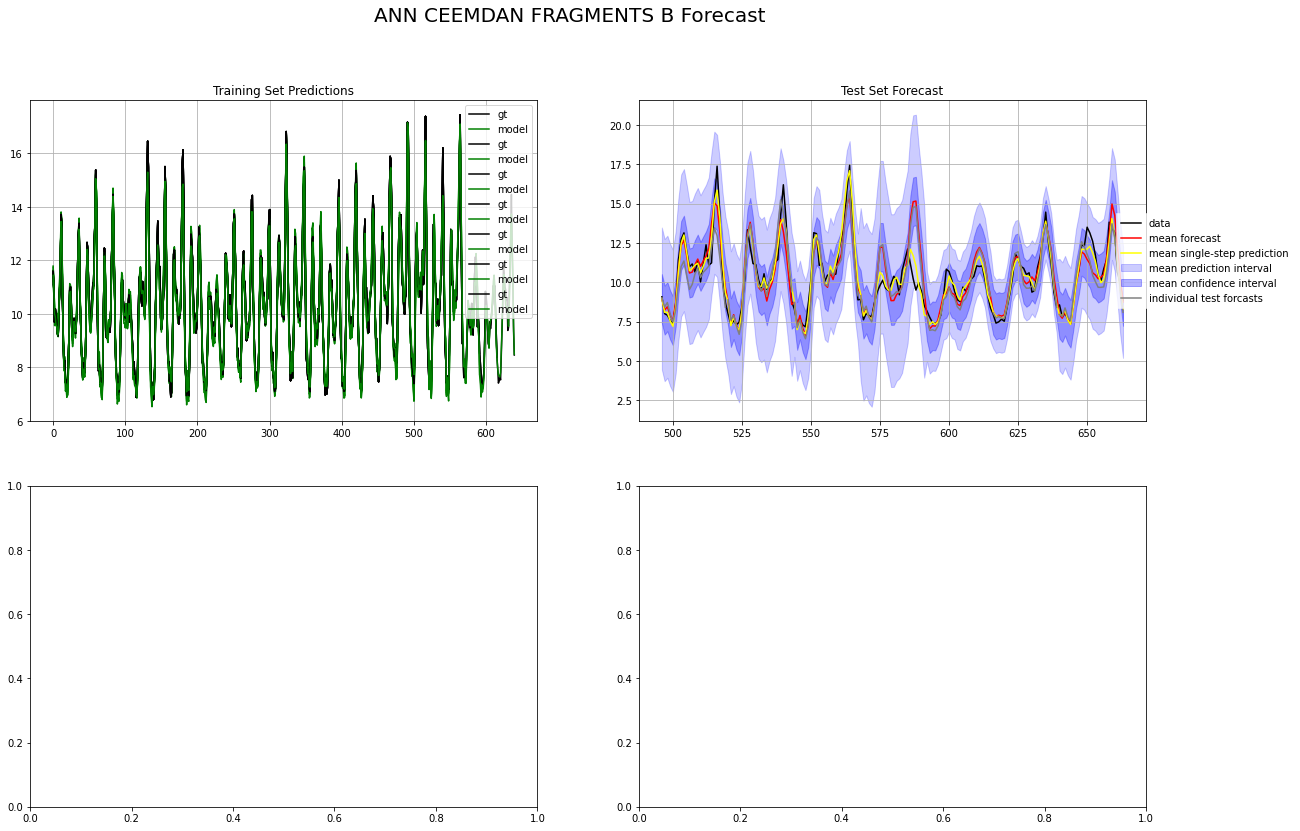

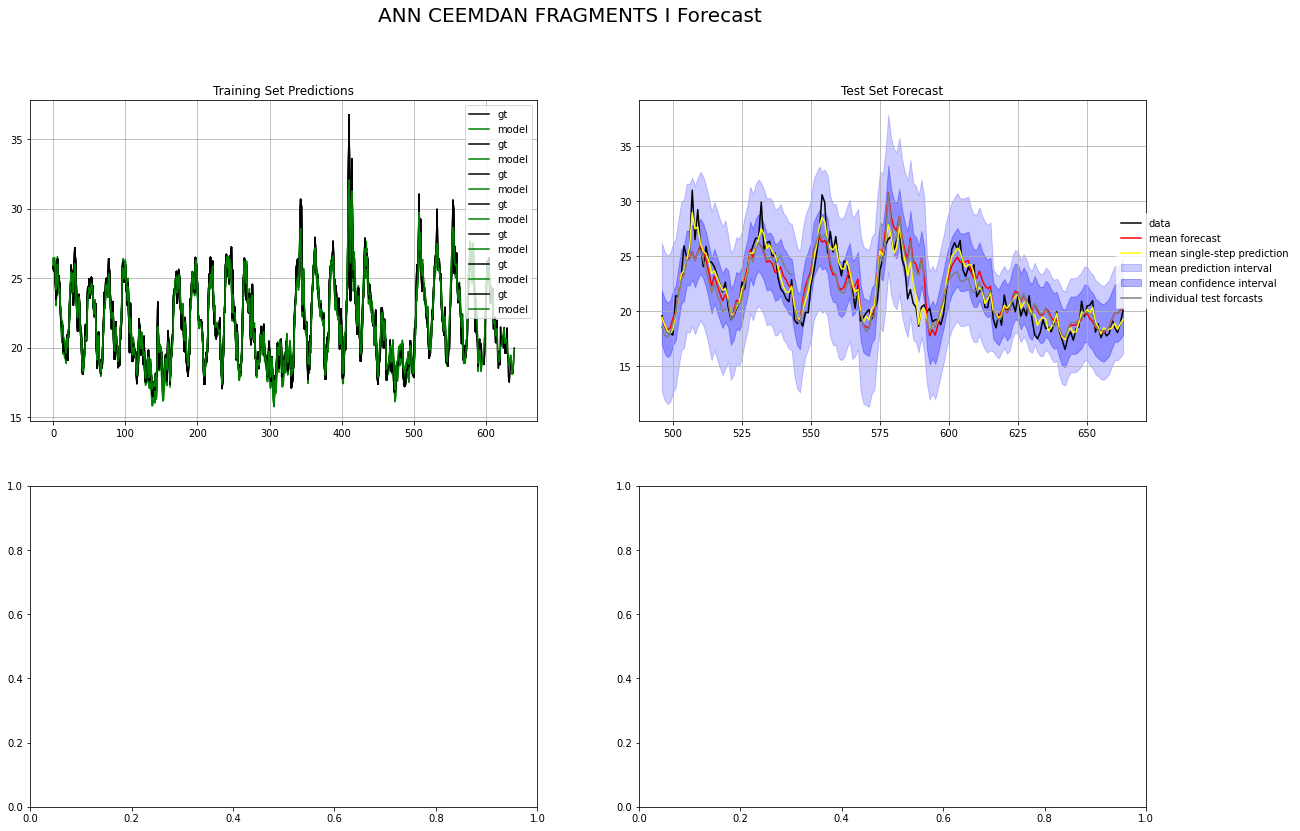

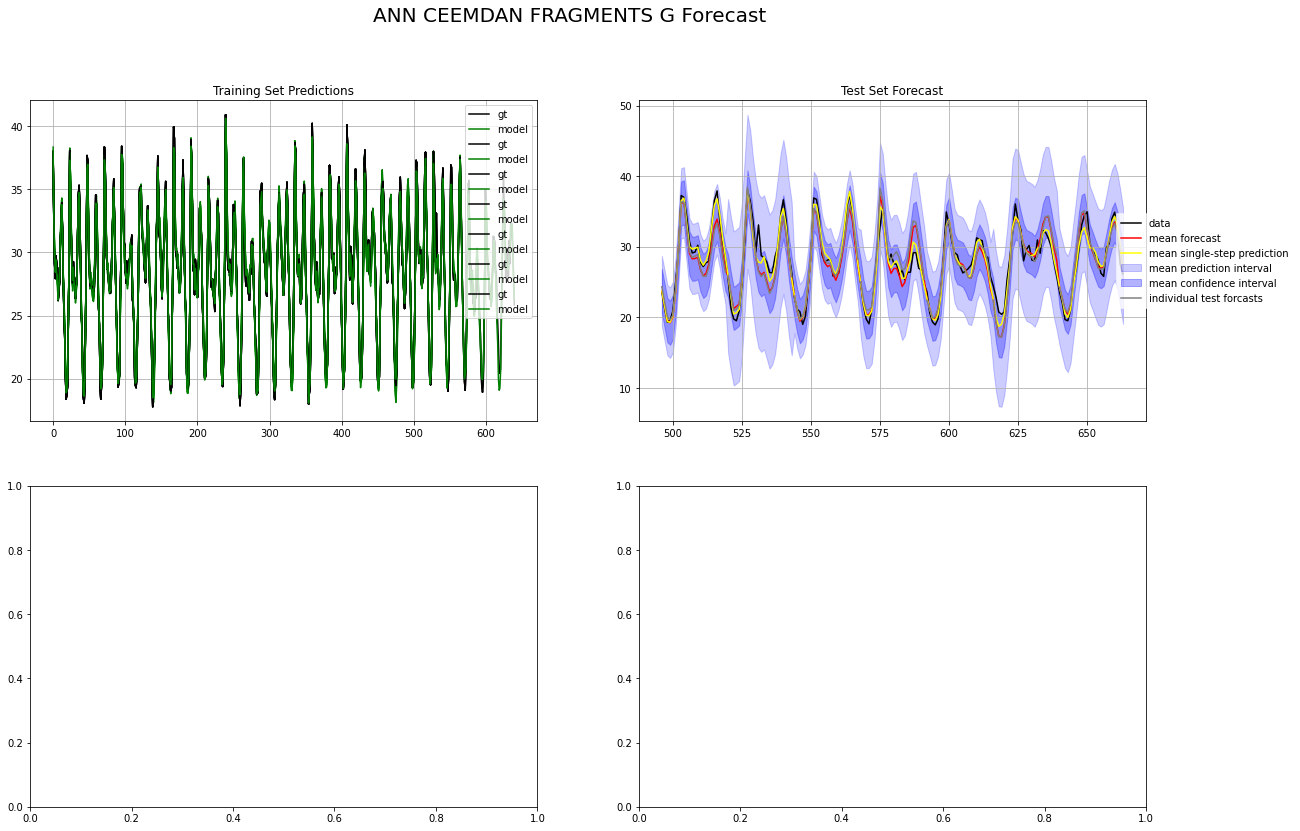

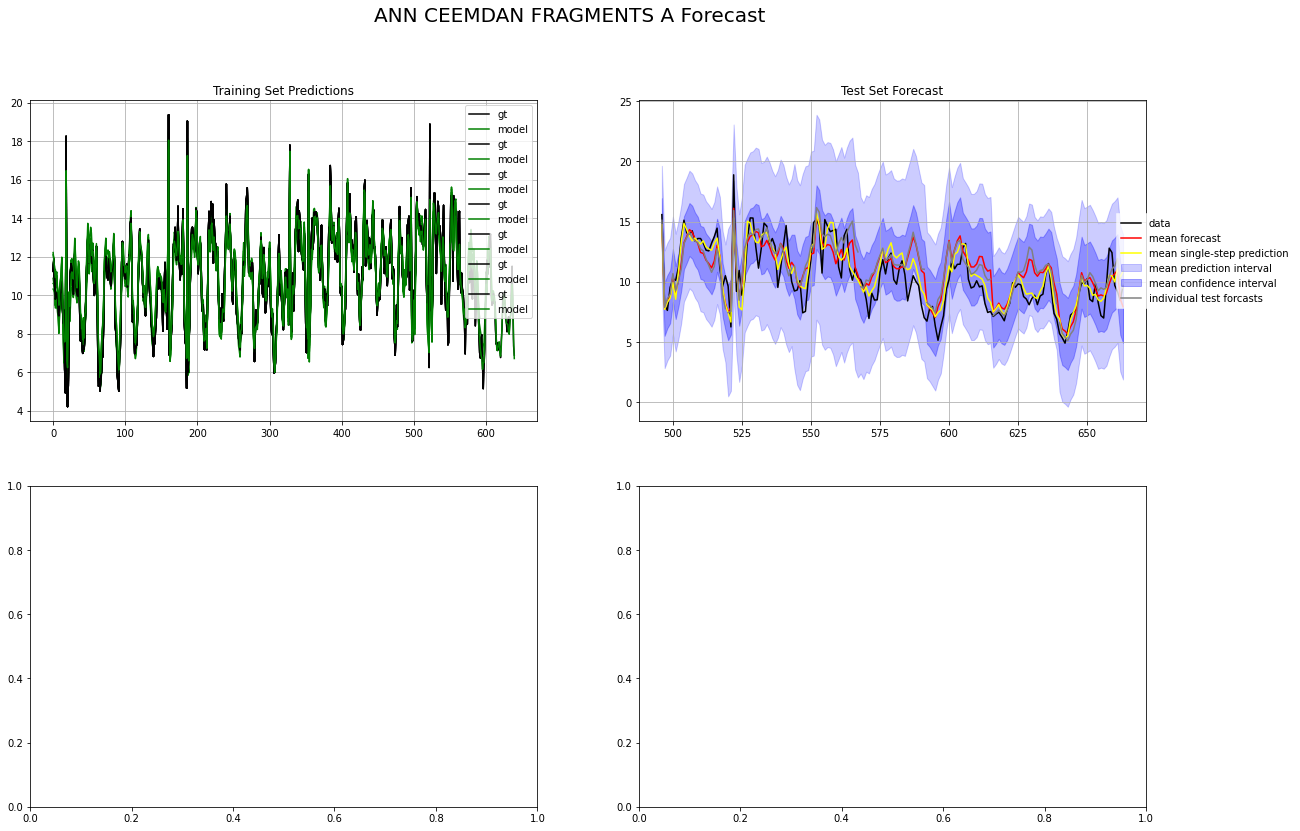

In [360]:
# plotting extended foecast and multiple cross validations
experiment = 'ANN CEEMDAN FRAGMENTS'
plot_df = forecast_datasets[experiment].keys()
plot_multi_model_evaluation(forecast_datasets, experiment=experiment)

In [237]:
comparison_df.sort_index(axis=1)

,ANN BASIC FRAGMENT A,ANN BASIC FRAGMENT B,ANN BASIC FRAGMENT G,ANN BASIC FRAGMENT I,ANN BASIC V2 A,ANN BASIC V2 B,ANN BASIC V2 G,ANN BASIC V2 I,ANN BASIC VIRTUAL A,ANN BASIC VIRTUAL B,ANN BASIC VIRTUAL G,ANN BASIC VIRTUAL I,ANN CEEMDAN FRAGMENTS A,ANN CEEMDAN FRAGMENTS B,ANN CEEMDAN FRAGMENTS G,ANN CEEMDAN FRAGMENTS I,ANN DWT FRAGMENTS A,ANN DWT FRAGMENTS B,ANN DWT FRAGMENTS G,ANN DWT FRAGMENTS I
MSE,4.078743,1.469097,3.043098,2.692569,4.344604,1.647069,2.729936,2.567555,4.870266,1.817310,4.393111,3.207994,3.509067,1.440176,3.408123,3.365140,4.181149,1.389728,2.537762,2.464678
MSE_std,0.209279,0.125690,0.173239,0.211988,0.210373,0.167836,0.225183,0.447670,0.238433,0.207744,0.331992,0.424913,3.829172,2.472193,4.556668,4.329602,4.644218,2.380080,4.452755,3.818947
MAPE,0.176333,0.080255,0.044937,0.056237,0.194743,0.091064,0.043303,0.055108,0.207999,0.102903,0.062424,0.065677,0.158581,0.079374,0.050892,0.062461,0.183833,0.078115,0.039811,0.052390
MAPE_std,0.005241,0.002141,0.001309,0.002639,0.006023,0.003623,0.001417,0.004532,0.005730,0.005349,0.002350,0.003719,0.116960,0.064841,0.036546,0.044593,0.144365,0.061245,0.032783,0.040248


In [359]:
def plot_multi_model_evaluation(forecast_dataset, experiment, save_dir=None, figsize=(20,13), save_fig=False):
    '''
    Plot model's predictions on training and test sets, along with key performance metrics.
    :param forecast_df: DataFrame consisting of predicted and ground truth consumption values
    :param model_name: model identifier
    :param metrics: key performance metrics
    :param figsize: size of matplotlib figure
    :param train_date: string representing date model was trained
    '''

    # assign df for specific experiment
    experiment_df = forecast_dataset[experiment]
    
    for dma in experiment_df.keys(): 
        # assign df for specific dma
        df_dma = experiment_df[dma].copy()
        
        no_folds = max([int(col[-3]) for col in df_dma.columns])+1
        no_test = max([int(col[-1]) for col in df_dma.columns])+1
        pointer = 0
        width_df = int((df_dma.shape[1]-10) / (no_folds * no_test))
        forecast_df = df_dma.rename(columns={col: col[:-9] for col in df_dma.columns}).copy()
        
        # initialise figure
        fig = plt.figure(figsize=figsize)
        fig.suptitle(experiment+' '+dma+' Forecast', fontsize=20)
        ax1 = fig.add_subplot(2, 2, 1)
        ax2 = fig.add_subplot(2, 2, 2)
        ax3 = fig.add_subplot(2, 2, 3)
        ax4 = fig.add_subplot(2, 2, 4)
        
        # Plot test performance
        if "test_pred" in forecast_df.columns:
            forecast_df[pd.isnull(df_dma["model_fold_0_0"])][["mean_gt", "mean_forecast", "mean_test_pred"]].plot(color=["black", "red", "yellow"],
                                                                                title="Test Set Forecast", grid=True, ax=ax2)
        else:
            forecast_df[pd.isnull(df_dma["model_fold_0_0"])][["mean_gt", "mean_forecast"]].plot(color=["black", "red"],
                                                                                title="Test Set Forecast", grid=True, ax=ax2)
        ax2.fill_between(x=forecast_df.index, y1=forecast_df['mean_pred_int_low'], y2=forecast_df['mean_pred_int_up'], color='b', alpha=0.2)
        ax2.fill_between(x=forecast_df.index, y1=forecast_df['mean_conf_int_low'], y2=forecast_df['mean_conf_int_up'], color='b', alpha=0.3)
        ax2.set(xlabel=None)
        
        # iterate over each fold
        for test in range(no_test): 
            for fold in range(no_folds): 
                forecast_df = df_dma.rename(columns={col: col[:-9] for col in df_dma.columns}).copy().iloc[:, pointer: pointer+width_df]
                print(forecast_df)

                # Split indivudiual validations
                #run_dict = {forecast_df.columns}

                # Plot training performance
                forecast_df[pd.notnull(forecast_df["model"])][["gt", "model"]].plot(color=["black", "green"], title="Training Set Predictions",
                                                                                    grid=True, ax=ax1)
                ax1.set(xlabel=None)

                # Plot test performance
                forecast_df[pd.isnull(forecast_df["model"])][["forecast"]].plot(color=["grey"],
                                                                                        title="Test Set Forecast", grid=True, ax=ax2)
                #ax2.fill_between(x=forecast_df.index, y1=forecast_df['pred_int_low'], y2=forecast_df['pred_int_up'], color='b', alpha=0.2)
                #ax2.fill_between(x=forecast_df.index, y1=forecast_df['conf_int_low'], y2=forecast_df['conf_int_up'], color='b', alpha=0.3)
                #ax2.set(xlabel=None)

                # Plot residuals
                #forecast_df[["residuals", "error"]].plot(ax=ax3, color=["green", "red"], title="Residuals", grid=True)
                #ax3.set(xlabel=None)

                # Plot residuals distribution
                #forecast_df[["residuals", "error"]].plot(ax=ax4, color=["green", "red"], kind='kde',
                #                                title="Residuals Distribution", grid=True)
                #ax4.set(ylabel=None)

                if save_fig:
                    save_dir = cfg['PATHS']['FORECAST_VISUALIZATIONS'] if save_dir is None else save_dir
                    plt.savefig(save_dir + '/' + model_name + '_eval_' +
                                train_date + '.png')
                
                # update pointer
                pointer += width_df 
            
            ax2_labels = ['data', 'mean forecast', 'mean single-step prediction', 'mean prediction interval', 'mean confidence interval', 'individual test forcasts']
            leg = ax2.legend(ax2_labels, loc='right', bbox_to_anchor=(1.3, 0.5),
            fancybox=False, shadow=False, ncol=1, edgecolor='w', borderpad=0.5)
            leg.get_frame().set_linewidth(0.5)
            break
    return


def decomposition_metrics(forecast_df):
    '''
    Return metrics relating to mode performance for a single fold.
    :param forecast_df: DataFrame consisting of predicted and ground truth consumption values
    '''
    metrics = {}
    metrics['residuals_mean'] = forecast_df["residuals"].mean()
    metrics['residuals_std'] = forecast_df["residuals"].std()
    metrics['error_mean'] = forecast_df["error"].mean()
    metrics['error_std'] = forecast_df["error"].std()
    metrics['MAE'] = forecast_df["error"].apply(lambda x: np.abs(x)).mean()
    forecast_df["error_pct"] = forecast_df["error"] / forecast_df["gt"]
    metrics['MAPE'] = forecast_df["error_pct"].apply(lambda x: np.abs(x)).mean()
    metrics['MSE'] = forecast_df["error"].apply(lambda x: x ** 2).mean()
    metrics['RMSE'] = np.sqrt(metrics['MSE'])  # root mean squared error
    metrics['MAE_std'] = forecast_df["error"].apply(lambda x: np.abs(x)).std()
    metrics['MAPE_std'] = forecast_df["error_pct"].apply(lambda x: np.abs(x)).std()
    metrics['MSE_std'] = forecast_df["error"].apply(lambda x: x ** 2).std()
    metrics_df = pd.DataFrame.from_records([metrics])

    return metrics_df